# Machine Learning with Spark
                                                             21/03/2018

## Challenge: Network Intrusion Detection

Network intrusion is a common security problem in large and medium size companies. Being able to find ‘patterns’ in the network traffic allows to implement preemptive actions that save money to companies.

The goal of the challange is to play around with the pyspark library while buildind a machine learning model that will differentiate between 'good' or 'normal' connections and network 'intrusions' or 'attacks'.

---

**[Dataset site](https://www.unb.ca/cic/datasets/nsl.html)**

In [1]:
# Initialization. Libraries imported in alphabetical order.
from collections import Counter

import findspark
import matplotlib.pyplot as plt
import os
import pandas as pd

import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, monotonically_increasing_id
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression, RandomForestClassifier, GBTClassifier
)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import (
    OneHotEncoder, 
    StringIndexer, 
    StandardScaler,
    VectorAssembler,
    IndexToString,
    VectorIndexer
)

import seaborn as sns
import time

# Configurations.
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

%matplotlib inline 

# Constants
START_TIME = time.time()

In [2]:
# Create a SparkSession and specify configuration.
spark = SparkSession\
    .builder.master("local")\
    .config("spark.driver.cores", 4)\
    .appName("intrusion-detection").getOrCreate()

spark

In [4]:
# Reading data files with all info and assigning correct colNames.
train_set = spark.read.option("inferSchema", "true").csv(
    "./data/KDDTrain+.txt"
)
test_set = spark.read.option("inferSchema", "true").csv("./data/KDDTest+.txt")

features = [
    "duration",
    "protocol_type",
    "service",
    "flag","src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login", 
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate", 
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate", 
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count", 
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", 
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", 
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", 
    "dst_host_srv_rerror_rate",
    "label",
    "times_correctly_classified"
]

rawnames = train_set.schema.names

def updateColNames(df, oldnames, newnames):
    """Definition to rename a spark 'dataframe' columns"""
    
    for i in range(len(newnames)):
        df = df.withColumnRenamed(oldnames[i], newnames[i])
        
    return df

train_set = updateColNames(train_set,rawnames,features)
test_set = updateColNames(test_set,rawnames,features)

test_set.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- srv

In [5]:
# Get list of strings and numerical columns.
str_list = [item[0] for item in train_set.dtypes if item[1].startswith(
    'string'
)]
num_list = [item[0] for item in train_set.dtypes if item[1].startswith(
    ('int','double')
)]

**Inspect data**

In [6]:
print(
    f"Shape of the train dataset: {train_set.toPandas().shape}\n"
    f"Shape of the test dataset: {test_set.toPandas().shape}"
)

Shape of the train dataset: (125973, 43)
Shape of the test dataset: (22544, 43)


In [56]:
# Join datasets so that transformations and analysis is performed only 
# once.
df = train_set.union(test_set)
print(f"Rows in the joined dataframe: {df.count()}")

Rows in the joined dataframe: 148517


In [8]:
# Describe all the variables.
df.toPandas().describe(include="all")

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,times_correctly_classified
count,148517.000000,148517,148517,148517,1.485170e+05,1.485170e+05,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.0,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517,148517.000000
unique,NaN,3,70,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,NaN
top,NaN,tcp,http,SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,NaN
freq,NaN,121569,48191,89820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77054,NaN
mean,276.779305,NaN,NaN,NaN,4.022795e+04,1.708885e+04,0.000215,0.020523,0.000202,0.189379,0.004323,0.402789,0.255062,0.001508,0.000976,0.273726,0.012073,0.000525,0.004013,0.0,0.000081,0.012308,83.336561,28.251937,0.256925,0.255337,0.137947,0.138487,0.672983,0.067761,0.097441,183.928042,119.462661,0.534521,0.084103,0.145932,0.030584,0.256122,0.251304,0.136220,0.136397,NaN,19.278480
std,2460.683131,NaN,NaN,NaN,5.409612e+06,3.703525e+06,0.014677,0.240069,0.019417,2.013160,0.072248,0.490461,22.231375,0.038807,0.042389,22.689023,0.517863,0.027701,0.095257,0.0,0.008988,0.110259,116.760741,75.369635,0.431918,0.432578,0.339387,0.341783,0.436544,0.194666,0.258886,98.528328,111.232318,0.448061,0.194102,0.308638,0.108975,0.428500,0.429719,0.322741,0.335282,NaN,2.739757
min,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,87.000000,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,18.000000
50%,0.000000,NaN,NaN,NaN,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,13.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,72.000000,0.600000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,20.000000
75%,0.000000,NaN,NaN,NaN,2.780000e+02,5.710000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,141.000000,17.000000,0.850000,0.910000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.050000,0.010000,0.600000,0.500000,0.000000,0

In [9]:
# We can see that the variable num_outbound_cmds is composed by only
# zeroes. We can delete it.
df = df.drop('num_outbound_cmds')
num_list.remove('num_outbound_cmds')

In [10]:
# The feature'su_attempted' should be a binary feature, 
# but has 3 factors.
Counter(df.toPandas().su_attempted)

Counter({0: 148433, 1: 23, 2: 61})

In [11]:
# 'Replace the value 2.0 for 0.0.
df = df.replace(2.0, 0.0, 'su_attempted')

# There are no null values on the dataset.
df.toPandas().isnull().sum()

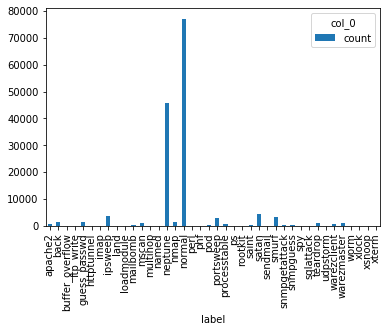

In [13]:
# Plot the frequency of the factors in the label variable.
my_tab = pd.crosstab(index=df.toPandas()["label"], columns="count")
my_tab.plot.bar();

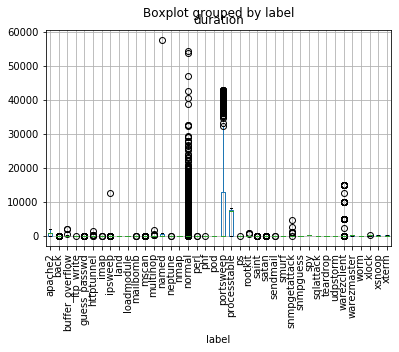

In [14]:
# Inspect the distribution of connection time in "duration" by type of 
# connection.
ax = df.toPandas().boxplot(column="duration", by= "label")

for tick in ax.get_xticklabels():
    tick.set_rotation(90);

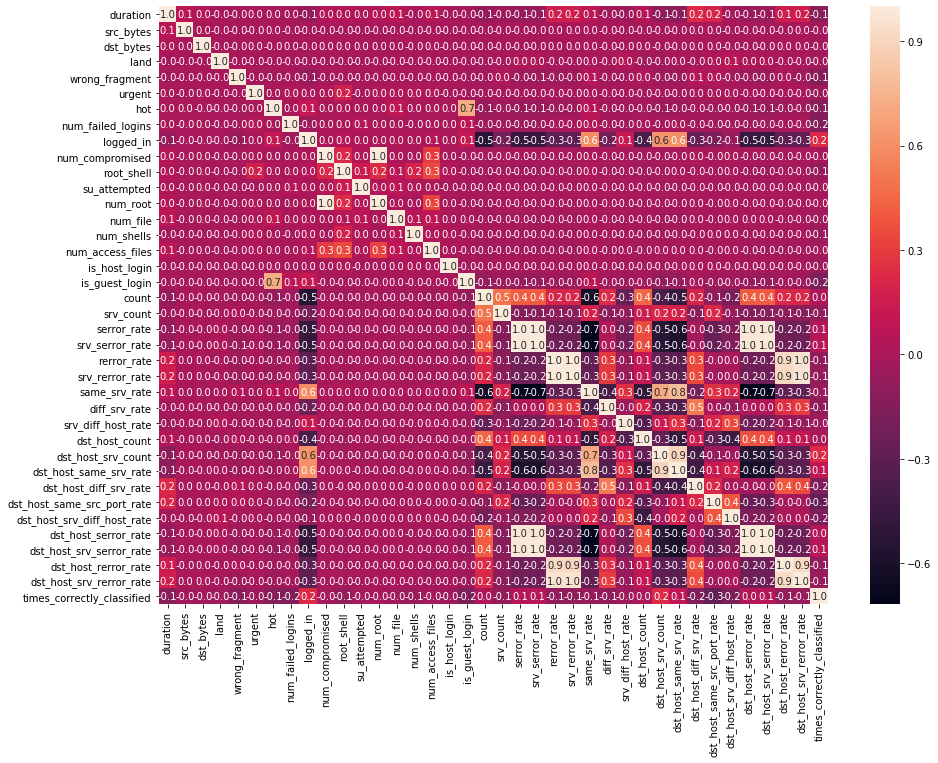

In [15]:
# Correlation heatmap.
fig, ax = plt.subplots()
fig.set_size_inches(15, 11)
sns.heatmap(df.toPandas().corr(), annot=True, fmt=".1f");

**Preprocess Data**

In [16]:
# Create a binary target variable. The connection will be either 'good'
# (0) or 'bad' (1).
binarize = lambda x: 1 if x != 'normal' else 0
udf_value_to_category = udf(binarize, IntegerType())
df = df.withColumn("label2", udf_value_to_category("label"))
pd.crosstab(index = df.toPandas()["label2"], columns="count")

col_0,count
label2,
0,77054
1,71463


In [17]:
categorical_columns = ["protocol_type", "service", "flag"]

# Stages in pipeline.
stages = [] 

for col in categorical_columns:
    # Category indexing with StringIndexer.
    indexer = StringIndexer(inputCol=col, outputCol=col+"_index")
    
    # Use OneHotEncoder to convert categorical variables into binary 
    # SparseVectors.
    encoder = OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vector")
    
    # Add stages. These are not run here, but will run all at once 
    # later on.
    stages += [indexer, encoder]
    
    
# Transform all numerical features into a vector using VectorAssembler.
assembler_inputs = [ 
    col + "_vector" for col in categorical_columns 
] + num_list

assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [assembler]

### Modeling

Next we will build a baseline model and will play with a couple of the ML algorithms available in pyspark.

In [19]:
# List of the stages that the imported dataset will follow.
stages

[StringIndexer_0a482adf42f6,
 OneHotEncoder_204bb3e4b420,
 StringIndexer_ffa9a63305a0,
 OneHotEncoder_31ea164fc8a1,
 StringIndexer_9017fb6f195c,
 OneHotEncoder_6f6f30cfbca5,
 VectorAssembler_2f586d599cc8]

In [20]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

# Run the feature transformations.
transformer = pipeline.fit(df)
transformed_df = transformer.transform(df)

selection = ["features", "label2"] 
dataset = transformed_df.select(selection)

# Change column name
dataset = dataset.selectExpr("features as features", "label2 as label")
dataset.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(119,[0,6,71,82,9...|    0|
|(119,[1,7,71,82,9...|    0|
|(119,[0,3,72,99,1...|    1|
|(119,[0,2,71,82,8...|    0|
|(119,[0,2,71,82,8...|    0|
|(119,[0,3,73,99,1...|    1|
|(119,[0,3,72,99,1...|    1|
|(119,[0,3,72,99,1...|    1|
|(119,[0,58,72,99,...|    1|
|(119,[0,3,72,99,1...|    1|
|(119,[0,3,73,99,1...|    1|
|(119,[0,3,72,99,1...|    1|
|(119,[0,2,71,82,8...|    0|
|(119,[0,6,71,82,8...|    1|
|(119,[0,40,72,99,...|    1|
|(119,[0,49,72,99,...|    1|
|(119,[0,2,71,82,8...|    0|
|(119,[8,71,82,99,...|    1|
|(119,[0,2,71,82,8...|    0|
|(119,[0,2,71,82,8...|    0|
+--------------------+-----+
only showing top 20 rows



In [22]:
# Split data again into train and test. First, add an index column:
dataset_i = dataset.withColumn('index', F.monotonically_increasing_id())

train_data = dataset.limit(train_set.count())
test_data = dataset_i.sort('index', ascending=False).limit(test_set.count())
test_data = test_data.drop('index')

print(
    f"Train dataset rows: {train_data.count()}\n"
    f"Test dataset rows: {test_data.count()}"
)

Train dataset rows: 125973
Test dataset rows: 22544


In [23]:
# Baseline model. Logistic regression.
lr = LogisticRegression(maxIter=100, regParam=0.3, labelCol = 'label')

# Fit the model
lrModel = lr.fit(train_data)

# Make predictions.
predictions = lrModel.transform(test_data)
predictions.select('features', 'label', 'prediction', 'probability').show(10)

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(119,[0,35,73,99,...|    1|       1.0|[0.12904438358994...|
|(119,[1,4,71,82,8...|    0|       0.0|[0.91778892678354...|
|(119,[0,2,71,82,8...|    1|       0.0|[0.84810485211336...|
|(119,[0,2,71,82,8...|    0|       0.0|[0.92423497618017...|
|(119,[0,5,71,82,8...|    0|       0.0|[0.91142109499502...|
|(119,[10,71,82,99...|    1|       0.0|[0.54699339073476...|
|(119,[0,5,71,81,8...|    1|       0.0|[0.74445925908294...|
|(119,[0,20,73,99,...|    1|       1.0|[0.19675774706412...|
|(119,[0,2,71,82,8...|    0|       0.0|[0.93085752152859...|
|(119,[0,3,73,99,1...|    1|       1.0|[0.15444333471820...|
+--------------------+-----+----------+--------------------+
only showing top 10 rows



In [24]:
# Evaluate predictions.
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9477054329003228


In [60]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='label',
    predictionCol='prediction',
    probabilityCol='probability',
    rawPredictionCol='rawPrediction',
    maxDepth=7,
    maxBins=64,
    maxMemoryInMB=512,
    checkpointInterval=10,
    impurity='gini',
    numTrees=1000,
    featureSubsetStrategy='auto',
    seed=123,
)

In [61]:
# Random Forests
# rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_data)

Py4JJavaError: An error occurred while calling o1715.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2550.0 failed 1 times, most recent failure: Lost task 0.0 in stage 2550.0 (TID 1700, localhost, executor driver): ExecutorLostFailure (executor driver exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 1401426 ms
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:743)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:742)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:742)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:567)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:201)
	at org.apache.spark.ml.classification.RandomForestClassifier$$anonfun$train$1.apply(RandomForestClassifier.scala:142)
	at org.apache.spark.ml.classification.RandomForestClassifier$$anonfun$train$1.apply(RandomForestClassifier.scala:120)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:185)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:185)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:120)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:46)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
predictions = rfModel.transform(test_data)
predictions.select('features', 'label', 'prediction', 'probability').show(10)

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

In [28]:
# Gradient-Boosted Tree Classifier
gbt = GBTClassifier(maxIter=100)
gbtModel = gbt.fit(train_data)

predictions = gbtModel.transform(test_data)
predictions.select('features', 'label', 'prediction', 'probability').show(10)

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(119,[0,35,73,99,...|    1|       1.0|[0.05856643021879...|
|(119,[1,4,71,82,8...|    0|       0.0|[0.98855593475771...|
|(119,[0,2,71,82,8...|    1|       1.0|[0.01192988384297...|
|(119,[0,2,71,82,8...|    0|       0.0|[0.98855593475771...|
|(119,[0,5,71,82,8...|    0|       0.0|[0.98855593475771...|
|(119,[10,71,82,99...|    1|       1.0|[0.01161609118736...|
|(119,[0,5,71,81,8...|    1|       1.0|[0.07336484295142...|
|(119,[0,20,73,99,...|    1|       1.0|[0.01175521609934...|
|(119,[0,2,71,82,8...|    0|       0.0|[0.98855593475771...|
|(119,[0,3,73,99,1...|    1|       1.0|[0.01175521609934...|
+--------------------+-----+----------+--------------------+
only showing top 10 rows



In [29]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9532897447845642


#### Create submission file

In [54]:
# The model with the best results was the Random Forest classifier.
rfModelFinal = rf.fit(train_data)
finalPredictions = rfModel.transform(test_data)
finalPredictions.select('features', 'label', 'prediction', 'probability').show(10)

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(119,[0,35,73,99,...|    1|       1.0|[0.26343220056585...|
|(119,[1,4,71,82,8...|    0|       0.0|[0.97579658474846...|
|(119,[0,2,71,82,8...|    1|       1.0|[0.45611703869644...|
|(119,[0,2,71,82,8...|    0|       0.0|[0.97056474418216...|
|(119,[0,5,71,82,8...|    0|       0.0|[0.95993099304506...|
|(119,[10,71,82,99...|    1|       1.0|[0.43251628940635...|
|(119,[0,5,71,81,8...|    1|       0.0|[0.71567295133705...|
|(119,[0,20,73,99,...|    1|       1.0|[0.01842065552831...|
|(119,[0,2,71,82,8...|    0|       0.0|[0.96935765151092...|
|(119,[0,3,73,99,1...|    1|       1.0|[0.01740219479007...|
+--------------------+-----+----------+--------------------+
only showing top 10 rows



In [38]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(finalPredictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9780391368686424


In [49]:
finalPredictions.toPandas()[['probability', 'prediction']].to_csv('final_predictions.csv', index=True)

In [ ]:
spark.stop() 